While the use of vehicles can be summarized relatively simply by annual miles traveled, stationary storage batteries may be utilized for a wide variety of applications, with varying stress on the battery. Here, we have a wide variety of example applications:
- Commercial PV-BESS: a simulation of the NREL site using NREL's [REopt tool](https://www.nrel.gov/reopt)
- Residential PV-BESS (CA, mild): a simulation of a California site using NREL's [REopt tool](https://www.nrel.gov/reopt)
- Residential PV-BESS(Germany, aggresive): a simulation of a battery pack using a greedy strategy for charging from real-world PV system data from Germany, source [Kucevic et al, 2020](https://linkinghub.elsevier.com/retrieve/pii/S2352152X19309016)
- Commercial Peak Shaving: real-world data from Germany, source [Kucevic et al, 2020](https://linkinghub.elsevier.com/retrieve/pii/S2352152X19309016)
- Frequency Containment Reserve: real-world data from Germany, source [Kucevic et al, 2020](https://linkinghub.elsevier.com/retrieve/pii/S2352152X19309016)
- Telecom backup power and peak shaving stacked application: real world power demands coupled with a system simulation using NREL [System Advisor Model](https://sam.nrel.gov)
- EV charging support for a rental car depot: simulated battery support for EV charging demands and optimized battery system size using NREL's [EVI-EDGES](https://www.nrel.gov/transportation/evi-edges.html)
- EV charging support for a public 'corner charging station', i.e., gas station equivalent: simulated battery support for EV charging demands and optimized battery system size using NREL's [EVI-EDGES](https://www.nrel.gov/transportation/evi-edges.html)

These applications are not necessarily representative of how batteries will be used in the real world under a similar application; for instance, see the large difference between the various PV-BESS operations, in terms of EFCs/year, DOD, and average SOC. To get an 'accurate' estimate of battery degradation for a specific system, specific details on how the system will be operated must be known.

This analysis does not assume any thermal variation; all simulations just assume a stable temperature of 30 Celsius.

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set_context('paper')

from blast.models import Lfp_Gr_250AhPrismatic, Nmc111_Gr_Kokam75Ah_Battery, Nca_Gr_Panasonic3Ah_Battery, Nmc622_Gr_DENSO50Ah_Battery

In [ ]:
# Load and summarize each profile
# It's a bit hacky, but we can use a battery model to automatically identify microcycles and extract stressors from each profile
applications = {
    'Commercial peak\nshaving': {'file':'Commercial peak shaving.csv'},
    'PV-BESS\n(CA, mild)': {'file':'Residential PV-BESS (CA, mild).csv'},
    'Telecom backup\npower': {'file':'Telecom backup power and peak shaving.csv'},
    'EV charging support\nrental car depot': {'file':'EV charging support rental car depot.csv'},
    'Commercial PV-BESS\n(NREL)': {'file':'Commercial PV-BESS (NREL).csv'},
    'Frequency containment\nreserve': {'file':'Frequency containment reserve.csv'},
    'PV-BESS\n(Germany, aggresive)': {'file':'Residential PV-BESS (Germany, aggressive).csv'},
    'EV charging support\ncorner charging station': {'file':'EV charging support corner charging station.csv'},
}
efc_per_year = []
efc_subcycle = []
t_subcycle = []
soc = []
soc_mean = []
soc_median = []
dod = []
dod_rms = []
dod_median = []
dod_95 = []
titles = []
for title in applications:
    app = pd.read_csv("application profiles/" + applications[title]['file'])
    applications[title]['data'] = app
    dSOC = app['SOC'].diff().fillna(0)
    efc = 0.5 * dSOC.abs().sum() * ((365*24*3600) / app['Time_s'].iloc[-1])
    # get stressors by simulating the profile; a bit hacky, but its fast enough so whatever
    batt = Lfp_Gr_250AhPrismatic()
    batt.simulate_battery_life(app)
    batt_soc = batt.stressors['soc'][1:]
    soc += (batt_soc.tolist())
    batt_dod = batt.stressors['dod'][1:]
    dod += (batt_dod.tolist())
    efc_subcycle += batt.stressors['delta_efc'][1:].tolist()
    t_subcycle += batt.stressors['delta_t_days'][1:].tolist()
    efc_per_year += (np.full_like(batt_soc, efc).tolist())
    dod_rms += (np.full_like(batt_soc, np.sqrt(np.mean(batt_dod**2))).tolist())
    dod_median += (np.full_like(batt_soc, np.median(batt_dod)).tolist())
    dod_95 += (np.full_like(batt_soc, np.percentile(batt_dod, 95)).tolist())
    soc_mean += (np.full_like(batt_soc, np.mean(batt_soc)).tolist())
    soc_median += (np.full_like(batt_soc, np.median(batt_soc)).tolist())
    titles += ([title] * len(batt_soc))

applications_summary = {
    'Application': titles,
    'EFCs/year': efc_per_year,
    'EFCs/subcycle': efc_subcycle,
    'Days/subcycle': t_subcycle,
    'Subcycle SOC': soc,
    'Mean SOC': soc_mean,
    'Median SOC': soc_median,
    'Subcycle DOD': dod,
    'DOD RMS': dod_rms,
    'Median DOD': dod_median,
    'DOD 95th percentile': dod_95,
}
applications_summary = pd.DataFrame.from_dict(applications_summary)

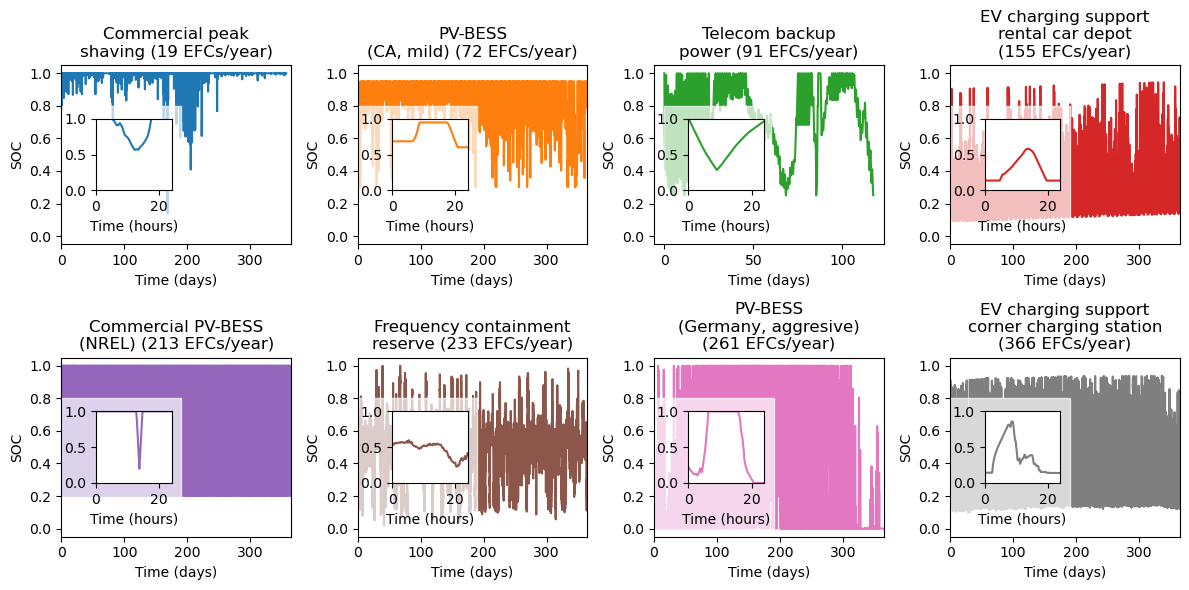

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',]
plot_day = [203.8, 207, 23, 260.1, 100.3, 104, 200.2, 269.9,]
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax = ax.ravel()

for axis, title, day, color in zip(ax, applications, plot_day, colors):
    app = applications[title]['data']
    axis.plot(app['Time_s'] / (24*3600), app['SOC'], color=color)
    if title != 'Telecom backup\npower':
        axis.add_artist(Rectangle((0, 0.), 190, 0.8, color='white', zorder=2, alpha=0.7))
    else:
        axis.add_artist(Rectangle((0, 0.), 60, 0.8, color='white', zorder=2, alpha=0.7))
    subax = axis.inset_axes([0.15, 0.3, 0.33, 0.4])
    dt = app['Time_s'].iloc[1] - app['Time_s'].iloc[0]
    subax.plot((app['Time_s'][int(day*24*3600/dt):int(day*24*3600/dt + (24*3600)/dt)] - app['Time_s'][int(day*24*3600/dt)]) / 3600,
            app['SOC'][int(day*24*3600/dt):int(day*24*3600/dt + (24*3600)/dt)], color=color)
    subax.axis([0, 24, 0, 1])
    subax.set_xlabel('Time (hours)')
    # subax.yaxis.tick_right()
    dSOC = app['SOC'].diff().fillna(0)
    efcs = 0.5 * dSOC.abs().sum() * ((365*24*3600) / app['Time_s'].iloc[-1])

    if len(title) > 27 and 'Frequency' not in title:
        axis.set_title(title + f'\n({int(efcs)} EFCs/year)')
    else:
        axis.set_title(title + f' ({int(efcs)} EFCs/year)')
    axis.set_xlabel('Time (days)')
    axis.set_ylabel('SOC')
    axis.set_ylim([-0.05, 1.05])
    if title != 'Telecom backup\npower':
        axis.set_xlim([0, 365])

plt.tight_layout()

C:\Users\pgasper\AppData\Local\Temp\1\ipykernel_29060\113299313.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, 'Commercial peak\nshaving'),
 Text(1, 0, 'PV-BESS\n(CA, mild)'),
 Text(2, 0, 'Telecom backup\npower'),
 Text(3, 0, 'EV charging support\nrental car depot'),
 Text(4, 0, 'Commercial PV-BESS\n(NREL)'),
 Text(5, 0, 'Frequency containment\nreserve'),
 Text(6, 0, 'PV-BESS\n(Germany, aggresive)'),
 Text(7, 0, 'EV charging support\ncorner charging station')]

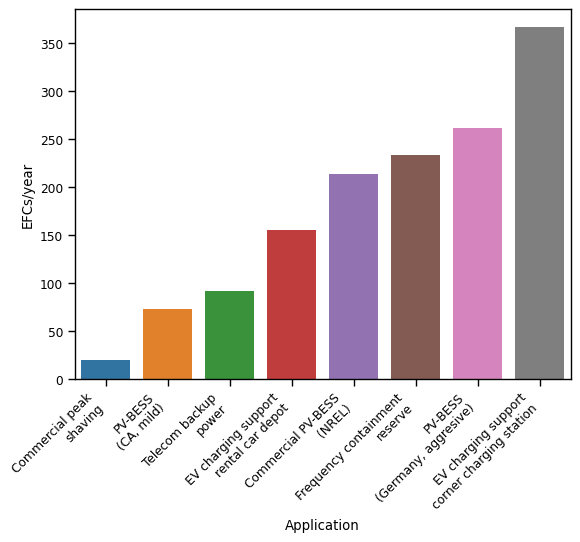

In [15]:
ax = sns.barplot(data=applications_summary.groupby(by='Application').mean(), x='Application', y='EFCs/year', hue='Application', order=[title for title in applications], hue_order=[title for title in applications])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

C:\Users\pgasper\AppData\Local\Temp\1\ipykernel_29060\2215441335.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, 'Commercial peak\nshaving'),
 Text(1, 0, 'PV-BESS\n(CA, mild)'),
 Text(2, 0, 'Telecom backup\npower'),
 Text(3, 0, 'EV charging support\nrental car depot'),
 Text(4, 0, 'Commercial PV-BESS\n(NREL)'),
 Text(5, 0, 'Frequency containment\nreserve'),
 Text(6, 0, 'PV-BESS\n(Germany, aggresive)'),
 Text(7, 0, 'EV charging support\ncorner charging station')]

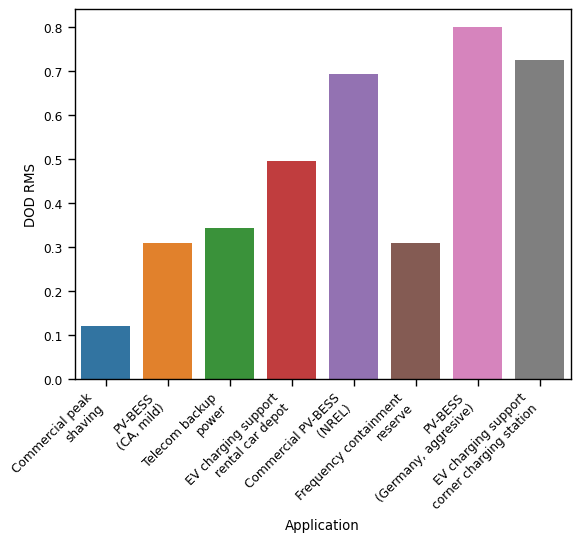

In [16]:
ax = sns.barplot(data=applications_summary.groupby(by='Application').mean(), x='Application', y='DOD RMS', hue='Application', order=[title for title in applications], hue_order=[title for title in applications])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

C:\Users\pgasper\AppData\Local\Temp\1\ipykernel_29060\444590298.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, 'Commercial peak\nshaving'),
 Text(1, 0, 'PV-BESS\n(CA, mild)'),
 Text(2, 0, 'Telecom backup\npower'),
 Text(3, 0, 'EV charging support\nrental car depot'),
 Text(4, 0, 'Commercial PV-BESS\n(NREL)'),
 Text(5, 0, 'Frequency containment\nreserve'),
 Text(6, 0, 'PV-BESS\n(Germany, aggresive)'),
 Text(7, 0, 'EV charging support\ncorner charging station')]

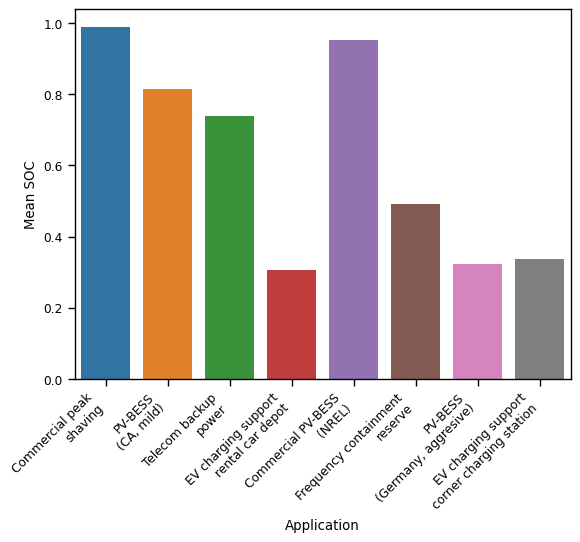

In [17]:
ax = sns.barplot(data=applications_summary.groupby(by='Application').mean(), x='Application', y='Mean SOC', hue='Application', order=[title for title in applications], hue_order=[title for title in applications])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

(0.0, 1.05)

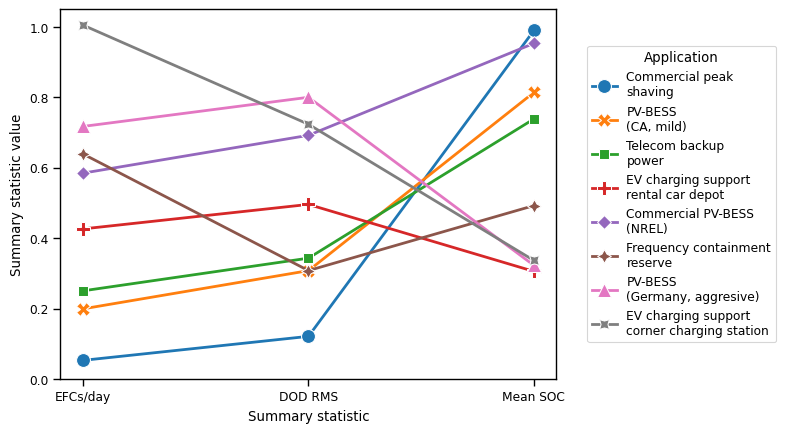

In [19]:
applications_summary['EFCs/day'] = applications_summary['EFCs/year'] / 365
df = applications_summary[['Application', 'EFCs/day', 'DOD RMS', 'Mean SOC']]
df = df.groupby(by='Application').mean()
df.reset_index(inplace=True)
df = df.melt(id_vars='Application', var_name='Summary statistic', value_vars=['EFCs/day', 'DOD RMS', 'Mean SOC'], value_name='Summary statistic value')

ax = sns.lineplot(data=df, x='Summary statistic', y='Summary statistic value', hue='Application', style='Application',
                  dashes=False, markers=True, markersize=10, linewidth=2, hue_order=[title for title in applications], style_order=[title for title in applications])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.move_legend(ax, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax.set_ylim([0, 1.05])

We can run simulations for several different battery types. It will become obvious that demanding applications require highly durable batteries to have any sort of reasonable lifetime.

Big caveat here: stationary storage systems usually are scoped for very long lifetimes, on the order of 20 or 30 years. This is well beyond the duration of any of the testing used to calibrate these models. Take all simulations with a HUGE grain of salt.

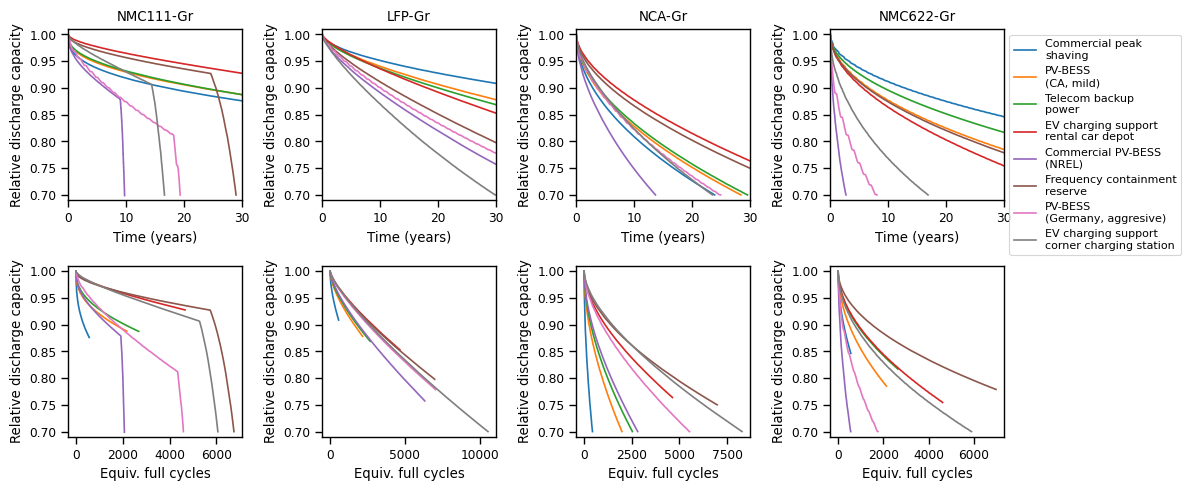

In [24]:
batteries = ['NMC111-Gr', 'LFP-Gr', 'NCA-Gr', 'NMC622-Gr']

fig, ax = plt.subplots(2, 4, figsize=(12,5))
for idx_ax, batt_type in enumerate(batteries):
    for idx_sim, title in enumerate(applications):
        if batt_type == 'LFP-Gr':
            batt = Lfp_Gr_250AhPrismatic()
        elif batt_type == 'NMC111-Gr':
            batt = Nmc111_Gr_Kokam75Ah_Battery()
        elif batt_type == 'NMC622-Gr':
            batt = Nmc622_Gr_DENSO50Ah_Battery()
        else:
            batt = Nca_Gr_Panasonic3Ah_Battery()
        
        batt.simulate_battery_life(applications[title]['data'], threshold_capacity=0.7, threshold_time=30)   

        ax[0][idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=title)
        ax[1][idx_ax].plot(batt.stressors['efc'], batt.outputs['q'], label=title)
        idx_sim += 1
        
    ax[0][idx_ax].set_xlabel('Time (years)')
    ax[0][idx_ax].set_ylabel('Relative discharge capacity')
    ax[0][idx_ax].set_ylim((0.69, 1.01))
    ax[0][idx_ax].set_xlim((0, 30))
    ax[1][idx_ax].set_xlabel('Equiv. full cycles')
    ax[1][idx_ax].set_ylabel('Relative discharge capacity')
    ax[1][idx_ax].set_ylim((0.69, 1.01))
    # ax[1][idx_ax].set_xlim((0, 6000))

    ax[0][idx_ax].set_title(batt_type)
    if idx_ax == 3:
        ax[0][idx_ax].legend(loc='upper left', fontsize=8, bbox_to_anchor=(1, 1))
    idx_ax += 1

plt.tight_layout()

Notice that some of these systems are degrading quite rapidly, getting below 80% capacity in less than 20 years. So, to meet the system energy/power requirements for 30 years, these systems would require replacement of the batteries. But, for a given energy/power requirement, you can always make the battery bigger to reduce the stress on the system, which will decrease degradation, but bigger batteries cost more. So, there is potentially a non-linear tradeoff between battery sizing and total cost, especially for batteries where the degradation is depth-of-discharge sensitive.

To make an broad analysis of this trade-off, we can run simulations where we 'derate' the load profile, i.e., pretend we are using a bigger battery than the one that was assumed when the load profile was generated. Then, we can calculate a '20-year cost factor', where a value of 1 corresponds to the cost of a nominally sized system that lasts exactly 20 years, derating the system increases the initial cost, and replacements incur additional cost. When derating, we also assume that we reduce the maximum SOC, which further extends life. Obviously, this excess capacity could be used for something if it was decided that the additional degradation was worth the cost; after the battery has degraded a bit, the incremental increase in degradation with increasing average SOC is not so much. But that complexity is left to more detailed analyses.

This analysis isn't accounting for important financial concepts like the time-value of money, learning curves for battery costs, residual values of the battery systems, or cheaper forms of battery maintenance such as augmentation rather than replacement.

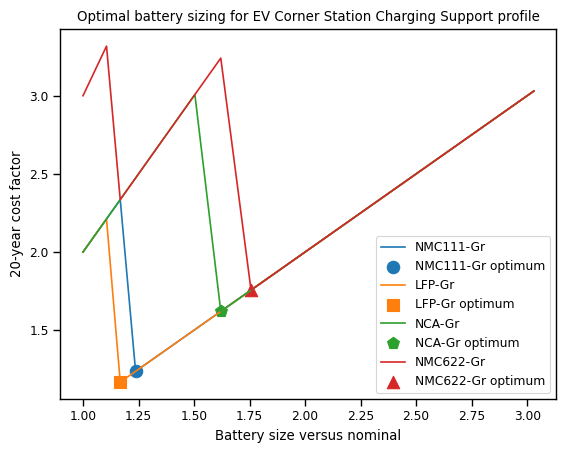

In [49]:
from blast.utils.functions import derate_profile
derating_factor = np.linspace(0, 0.67, 15)
battery_size = 1 / (1 - derating_factor)
batteries = ['NMC111-Gr', 'LFP-Gr', 'NCA-Gr', 'NMC622-Gr']
markers = ['o','s','p','^']
expected_lifetime = 20
end_of_life_capacity = 0.8
minimum_max_derated_soc = 0.8

input = applications['EV charging support\ncorner charging station']['data']

for battery, marker in zip(batteries, markers):
    if battery == 'LFP-Gr':
        Battery = Lfp_Gr_250AhPrismatic
    elif battery == 'NMC111-Gr':
        Battery = Nmc111_Gr_Kokam75Ah_Battery
    elif battery == 'NMC622-Gr':
        Battery = Nmc622_Gr_DENSO50Ah_Battery
    else:
        Battery = Nca_Gr_Panasonic3Ah_Battery

    cost_factor = []
    for derate in derating_factor:
        batt = Battery()
        if derate > 0:
            input_ = derate_profile(input.copy(), derate, max_soc=minimum_max_derated_soc)
        else:
            input_ = input.copy()
        base_cost = 1. / (1. - derate)
        batt.simulate_battery_life(input_, threshold_capacity=end_of_life_capacity)
        num_replacements = np.floor(expected_lifetime / (batt.stressors['t_days'][-1]/365))
        cost_factor.append(base_cost + base_cost * num_replacements)
    
    line = plt.plot(battery_size, cost_factor, '-', label=battery)
    idx_min = np.argmin(cost_factor)
    plt.scatter(battery_size[idx_min], cost_factor[idx_min], s=80, c=line[0].get_color(), marker=marker, label= battery + ' optimum')

plt.ylabel(f"{expected_lifetime}-year cost factor")
plt.xlabel('Battery size versus nominal')
plt.title('Optimal battery sizing for EV Corner Station Charging Support profile')
plt.legend()